Extract the key lines from Transport-Analysis to Give Figure 7

In [1]:
import arrow
import cmocean.cm as cm
import datetime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import pandas as pd
import pickle
import statsmodels.api as sm
import xarray as xr

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

In [3]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
#mesh = nc.Dataset('../../../myResults/mesh_mask201702.nc')
gdepw = mesh.variables['gdepw_1d'][0]
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
#bathy = nc.Dataset('../../../myResults/bathymetry_201702.nc')
lats = bathy.variables['nav_lat'][:]
lons = bathy.variables['nav_lon'][:]
gdept = mesh.variables['gdept_1d'][0]
mesh.close()
bathy.close()

In [4]:
def check_nan(ds):
    for j, index in enumerate(ds.index):
        if ds.transport[j] != ds.transport[j]:
            print (index)

### Density Forcing

In [6]:
sigma = pd.read_csv('sigma_2015_201806.csv', index_col=0)
m2015 = sigma.south - sigma.north
m2015.index = pd.to_datetime(m2015.index, format="%Y-%m-%d")

In [7]:
sigma = pd.read_csv('sigma_2016_201806.csv', index_col=0)
m2016 = sigma.south - sigma.north
m2016.index = pd.to_datetime(m2016.index, format="%Y-%m-%d")

In [8]:
sigma = pd.read_csv('sigma_2017_201806.csv', index_col=0)
m2017 = sigma.south - sigma.north
m2017.index = pd.to_datetime(m2017.index, format="%Y-%m-%d")

In [9]:
sigma = pd.read_csv('sigma_2018_201806.csv', index_col=0)
m2018 = sigma.south - sigma.north
m2018.index = pd.to_datetime(m2018.index, format="%Y-%m-%d")

In [55]:
goverrho=9.81/1000.
densitydiff = pd.concat([m2015, m2016, m2017, m2018])
densityforcing = np.sqrt(goverrho*densitydiff[:])
densityforcing.index = densityforcing.index.tz_convert(None)

### Tides

In [11]:
low_pass_tide = pd.read_csv('low_pass_tide.csv', index_col=0)
low_pass_tide.index = pd.to_datetime(low_pass_tide.index, format="%Y-%m-%d")

### Winds

In [12]:
wind = pd.read_csv('day_avg_wind.csv', index_col=0)
wind.index = pd.to_datetime(wind.index, format="%Y-%m-%d")
wind

,wind
time,
2015-01-01,-6.719084
2015-01-02,-2.420515
2015-01-03,-1.188265
2015-01-04,9.409819
2015-01-05,10.242579
...,...
2018-12-27,-1.132697
2018-12-28,4.772913
2018-12-29,9.158186


In [13]:
w_setup = (0.002 * 1.2 / 1000. * wind.wind * np.abs(wind.wind) / (0.02 * 50) * 100e3/50).rolling(window=30, center=True).mean()

### Richardson Number/Froude Number

In [14]:
smooth = densityforcing.rolling(window=4, center=True).mean()
smooth.index = smooth.index.tz_localize('UTC').tz_convert(None)
myfroude = low_pass_tide.vozocrtx/smooth**2
Ri = 1/myfroude

### Fluxes

In [15]:
deep_flux = pd.read_csv('deepflux.csv', index_col=0)
shallow_flux = pd.read_csv('shallowflux.csv', index_col=0)
deep_flux.index = pd.to_datetime(deep_flux.index, format="%Y-%m-%d")
shallow_flux.index = pd.to_datetime(shallow_flux.index, format="%Y-%m-%d")

In [16]:
baroclinic_flux = shallow_flux.transport + deep_flux.transport
baroclinic_flux.index = baroclinic_flux.index.tz_convert(None)

In [17]:
depthwidth = 50*10e3

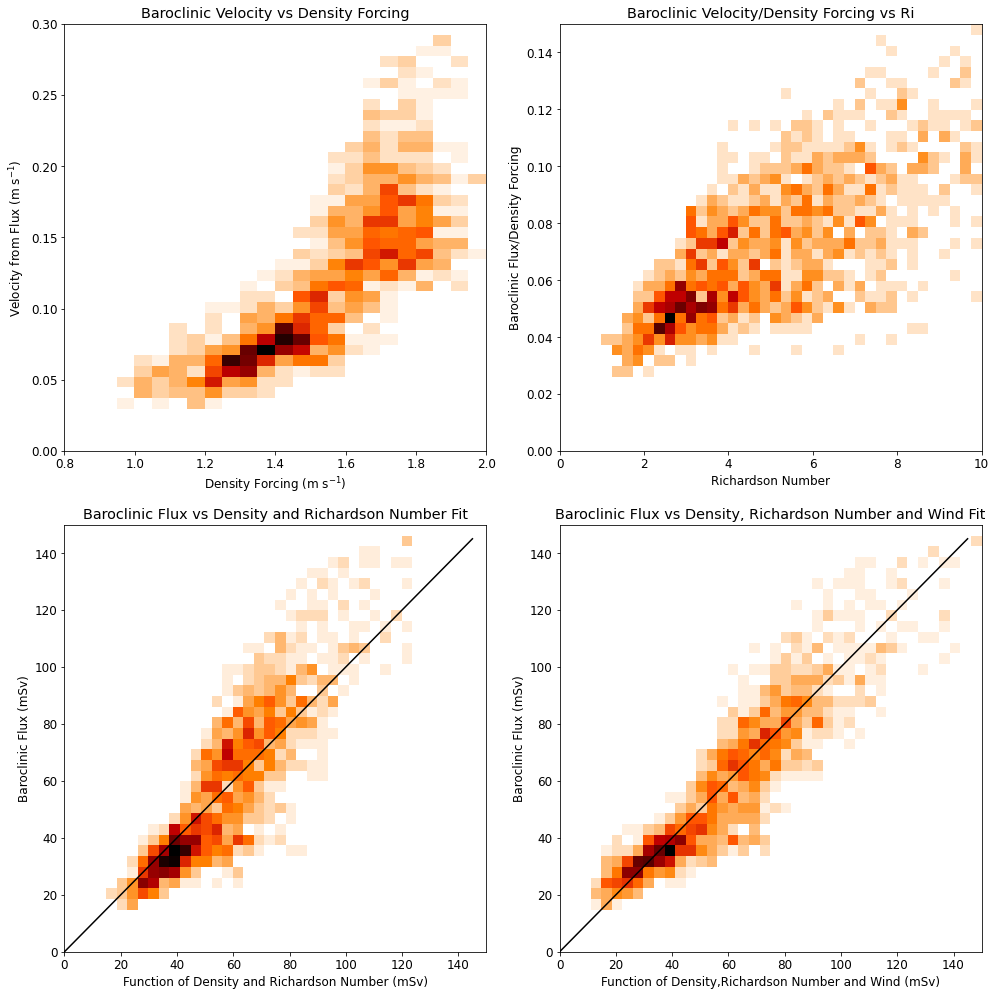

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(14, 14))
axs[0, 0].hist2d(densityforcing, baroclinic_flux[:]/depthwidth, range=[[0, 2.], [0, 0.3]], bins=40, cmap='gist_heat_r')
axs[0, 0].set_title("Baroclinic Velocity vs Density Forcing")
axs[0, 0].set_xlabel('Density Forcing (m s$^{-1}$)')
axs[0, 0].set_ylabel('Velocity from Flux (m s$^{-1}$)')
axs[0, 0].set_xlim(0.8, 2.)
axs[0, 0].set_ylim(0, 0.3)
axs[0, 1].hist2d(Ri, baroclinic_flux/depthwidth/densityforcing, range=[[0, 10], [0, 0.15]], bins=40, cmap='gist_heat_r');
axs[0, 1].set_title("Baroclinic Velocity/Density Forcing vs Ri")
axs[0, 1].set_xlabel('Richardson Number')
axs[0, 1].set_ylabel('Baroclinic Flux/Density Forcing')
axs[1, 0].hist2d(0.0325 * densityforcing.values * depthwidth*np.sqrt(Ri.values)/1e3, baroclinic_flux/1e3, range=[[0, 150], 
                                                                                                                 [0, 150]],
                 bins=40, cmap='gist_heat_r')
axs[1, 0].plot(np.arange(0, 150, 5), np.arange(0, 150, 5), 'k')
axs[1, 0].set_title("Baroclinic Flux vs Density and Richardson Number Fit")
axs[1, 0].set_xlabel('Function of Density and Richardson Number (mSv)')
axs[1, 0].set_ylabel('Baroclinic Flux (mSv)')

axs[1, 1].hist2d(((0.0339 * densityforcing.values - 0.0575 * w_setup.values) * depthwidth * np.sqrt(Ri).values)/1e3, baroclinic_flux/1e3, 
              range=[[0, 150], 
                                                                                                                 [0, 150]],
                 bins=40, cmap='gist_heat_r');
axs[1, 1].plot(np.arange(0, 150, 5), np.arange(0, 150, 5), 'k')

axs[1, 1].set_title("Baroclinic Flux vs Density, Richardson Number and Wind Fit")
axs[1, 1].set_xlabel('Function of Density,Richardson Number and Wind (mSv)')
axs[1, 1].set_ylabel('Baroclinic Flux (mSv)')

fig.tight_layout()
#fig.savefig('/home/sallen/MEOPAR/estuarine_flux_paper/density_forcing.pdf')
#fig.savefig('/home/sallen/MEOPAR/estuarine_flux_paper/density_forcing.png')

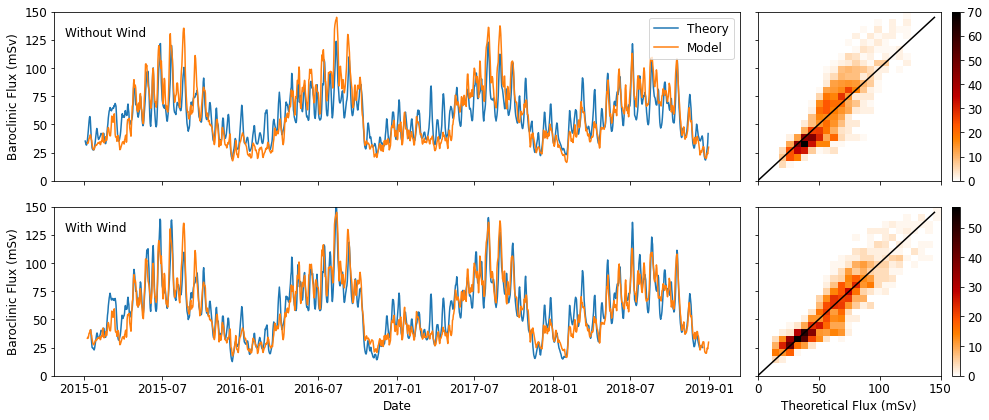

In [19]:
#f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
fig, axs = plt.subplots(2, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1]}, sharex='col', sharey='row', )
axs[0, 0].plot((densityforcing * depthwidth * 0.0325 * np.sqrt(Ri).values)/1e3, label='Theory');
axs[0, 0].plot(baroclinic_flux/1e3, label='Model')
axs[0, 0].set_ylabel('Baroclinic Flux (mSv)')
axs[0, 0].legend(loc='upper right')
fig.text(0.07, 0.9, 'Without Wind')
hist, xed, yed, colours = axs[0, 1].hist2d(0.0325 * densityforcing.values * depthwidth*np.sqrt(Ri.values)/1e3, baroclinic_flux/1e3, 
                 range=[[0, 150], [0, 150]], bins=25, cmap='gist_heat_r');
axs[0, 1].plot(np.arange(0, 150, 5), np.arange(0, 150, 5), 'k')
fig.colorbar(colours, ax=axs[0, 1]);

axs[1, 0].plot((0.0339 * densityforcing.values - 0.0575 * w_setup) * depthwidth * np.sqrt(Ri).values/1e3, label='Theory w Wind');
axs[1, 0].plot(baroclinic_flux/1e3, label='Model')
axs[1, 0].set_ylabel('Baroclinic Flux (mSv)')
#axs[1, 0].legend(loc='lower left')
axs[1, 0].set_xlabel('Date')
fig.text(0.07, 0.45, 'With Wind')
hist, xed, yed, colours = axs[1, 1].hist2d(((0.0339 * densityforcing.values - 0.0575 * w_setup.values) * depthwidth * np.sqrt(Ri).values)/1e3, 
                                           baroclinic_flux/1e3, 
                 range=[[0, 150], [0, 150]], bins=25, cmap='gist_heat_r');
axs[1, 1].plot(np.arange(0, 150, 5), np.arange(0, 150, 5), 'k')
fig.colorbar(colours, ax=axs[1, 1]);
axs[1, 1].set_xlabel('Theoretical Flux (mSv)')

fig.tight_layout();
#fig.savefig('/home/sallen/MEOPAR/estuarine_flux_paper/theory_fit.pdf')
#fig.savefig('/home/sallen/MEOPAR/estuarine_flux_paper/theory_fit.png')

From transport_analysis: Rsquared or variance explained is 95.1% and 97%, respectively.

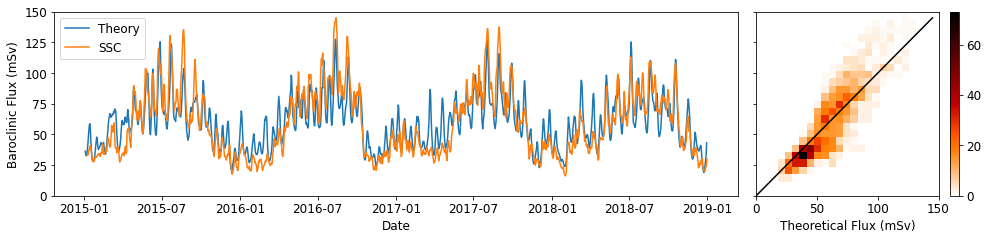

In [20]:
#f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
fig, axs = plt.subplots(1, 2, figsize=(14, 3.5), gridspec_kw={'width_ratios': [3, 1]}, sharex='col', sharey='row', )
axs[0].plot((densityforcing * depthwidth * 0.0335 * np.sqrt(Ri).values)/1e3, label='Theory');
axs[0].plot(baroclinic_flux/1e3, label='SSC')
axs[0].set_ylabel('Baroclinic Flux (mSv)')
axs[0].legend(loc='upper left')
hist, xed, yed, colours = axs[1].hist2d(0.0335 * densityforcing.values * depthwidth*np.sqrt(Ri.values)/1e3, baroclinic_flux/1e3, 
                 range=[[0, 150], [0, 150]], bins=25, cmap='gist_heat_r');
axs[1].plot(np.arange(0, 150, 5), np.arange(0, 150, 5), 'k')
fig.colorbar(colours, ax=axs[1]);

axs[0].set_xlabel('Date')
axs[1].set_xlabel('Theoretical Flux (mSv)')

fig.tight_layout();
#fig.savefig('/home/sallen/MEOPAR/estuarine_flux_paper/theory_fit_nw.pdf')
#fig.savefig('/home/sallen/MEOPAR/estuarine_flux_paper/theory_fit_nw.png')

## Calculate the yearly variation in the flux to compare to the table

In [45]:
annual_estimate = baroclinic_flux.groupby(baroclinic_flux.index.year).mean()
print (annual_estimate)
(annual_estimate[2017]-annual_estimate[2018])/annual_estimate.mean()

2015    59110.980707
2016    59329.579881
2017    59652.381287
2018    57539.710212
Name: transport, dtype: float64


0.03586380845552159

In [22]:
# Sanity Check
print ('2015', 0.5*(23.3+23.2+2.4+2.4+23.9+24.0+8.1+8.0))
print ('2016', 0.5*(24+23.7+2.1+2.1+24.2+24.0+7.9+7.8))

2015 57.64999999999999
2016 57.900000000000006


In [23]:
deep_flux.groupby(deep_flux.index.year).mean()

,transport
2015,26683.563787
2016,26785.802757
2017,26999.600567
2018,26532.935924


In [24]:
# Sanity Check
print ('2015', 0.5*(23.3+23.2+2.4+2.4))
print ('2016', 0.5*(24+23.7+2.1+2.1))

2015 25.65
2016 25.950000000000003


In [25]:
shallow_flux.groupby(shallow_flux.index.year).mean()

,transport
2015,32392.318331
2016,32543.777124
2017,32652.780719
2018,31006.774288


In [26]:
# Sanity Check
print ('2015', 0.5*(23.9+24.0+8.1+8.0))
print ('2016', 0.5*(24.2+24.0+7.9+7.8))

2015 32.0
2016 31.95


Also see some calculations in Transport-Analysis: basically fixing the time scale adds a bit of flux to the mean.  However the rank is correct.  2015-2017 similar.  2018 smaller.

In [27]:
theory = (densityforcing * depthwidth * 0.0335 * np.sqrt(Ri).values)
theory

2015-01-01             NaN
2015-01-02             NaN
2015-01-03    36315.756510
2015-01-04    34503.584711
2015-01-05    32994.653380
                  ...     
2018-12-27    26438.613041
2018-12-28    30095.643638
2018-12-29    34561.361321
2018-12-30    43205.573577
2018-12-31             NaN
Length: 1461, dtype: float64

In [28]:
raw_annual_theory = theory.groupby(theory.index.year).mean()

In [66]:
densitydiff*goverrho

2015-01-01 00:00:00+00:00    1.845435
2015-01-02 00:00:00+00:00    1.918297
2015-01-03 00:00:00+00:00    1.930509
2015-01-04 00:00:00+00:00    1.859343
2015-01-05 00:00:00+00:00    1.752873
                               ...   
2018-12-27 00:00:00+00:00    1.423626
2018-12-28 00:00:00+00:00    1.485563
2018-12-29 00:00:00+00:00    1.496672
2018-12-30 00:00:00+00:00    1.721671
2018-12-31 00:00:00+00:00    1.886177
Length: 1461, dtype: float64

In [67]:
df_annual = densityforcing.groupby(densityforcing.index.year).mean()
df2_annual = goverrho*(densitydiff.groupby(densityforcing.index.year)).mean()

In [70]:
low_pass_tide['vel'] = np.sqrt(low_pass_tide.vozocrtx)

In [71]:
tide_annual = low_pass_tide.groupby(low_pass_tide.index.year).vozocrtx.mean()
tideH_annual = low_pass_tide.groupby(low_pass_tide.index.year).vel.mean()

In [34]:
depthwidth * 0.0335 * df_annual**2/np.sqrt(tide_annual)

2015    54991.743525
2016    54436.085745
2017    56492.930680
2018    54344.530947
dtype: float64

In [74]:
annual_theory = depthwidth * 0.0335 * df_annual**2/np.sqrt(tide_annual)
annual_theory2 = depthwidth * 0.0335 * df2_annual/tideH_annual
annual_theory2

2015    57091.885533
2016    56814.561642
2017    58683.057195
2018    56604.851827
dtype: float64

0.026138509748409155
0.039014766680320924
0.03626974770329467


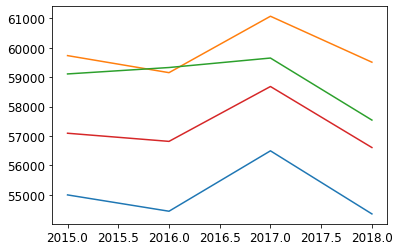

In [75]:
annual_theory.plot()
raw_annual_theory.plot()
annual_estimate.plot()
annual_theory2.plot()
print ((raw_annual_theory[2017]-raw_annual_theory[2018])/raw_annual_theory.mean())
print ((annual_theory[2017]-annual_theory[2018])/annual_theory.mean())
print ((annual_theory2[2017]-annual_theory2[2018])/annual_theory2.mean())

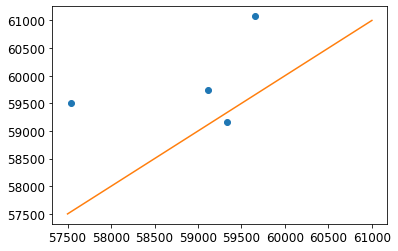

In [43]:
plt.plot(annual_estimate, raw_annual_theory, 'o')
plt.plot([57500, 61000], [57500, 61000])
#plt.plot(annual_estimate, raw_annual_theory, 'o')

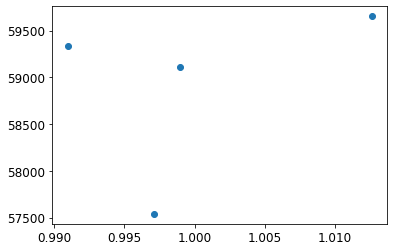

In [60]:
plt.plot(df_annual/1.54, annual_estimate, 'o')

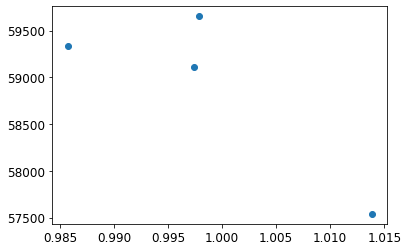

In [61]:
plt.plot(tide_annual/0.521, annual_estimate, 'o')

In [222]:
ssh = pd.read_csv('low_pass_ssh.csv')
ssh

,time_counter,sossheig
0,0,NaN
1,1,NaN
2,2,-0.056298
3,3,0.001114
4,4,0.028283
...,...,...
1456,1456,-0.001184
1457,1457,-0.012295
1458,1458,-0.041369
1459,1459,-0.080571


In [270]:
wcum = np.cumsum(wind)

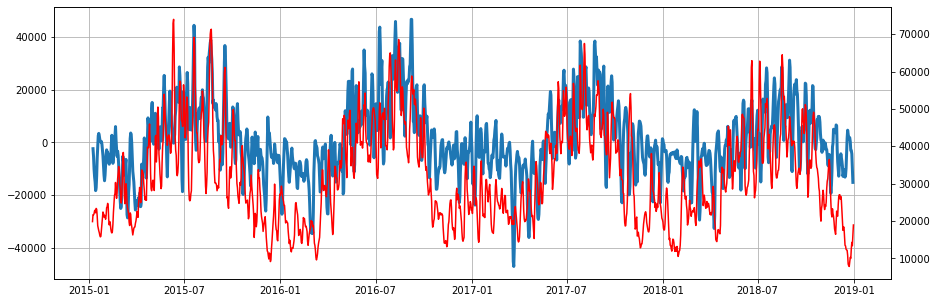

In [290]:
barotropic_flux = (shallow_flux.transport - deep_flux.transport)
slow_flux = barotropic_flux.rolling(window=30, center=True).mean()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
#ax.plot(barotropic_flux)
#ax.plot(slow_flux);
ax2 = ax.twinx();
#ax2.plot(w_setup, 'g');
ax.plot(
    (baroclinic_flux - 0.0325 * densityforcing.values * depthwidth*np.sqrt(Ri.values)),
    linewidth=3)
#ax.plot(baroclinic_flux - (0.0339 * densityforcing.values - 0.0575 * w_setup) * depthwidth * np.sqrt(Ri).values)
ax2.plot(shallow_flux.index, shallow_flux, 'r');
ax.grid()
#ax.set_xlim(datetime.datetime(2016, 1, 1), datetime.datetime(2017, 1, 1))

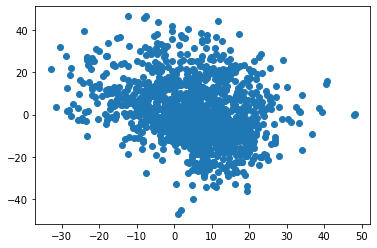

In [197]:
plt.plot(barotropic_flux/1e3, -0.0325 * densityforcing.values * depthwidth*np.sqrt(Ri.values)/1e3 + baroclinic_flux/1e3, 'o');

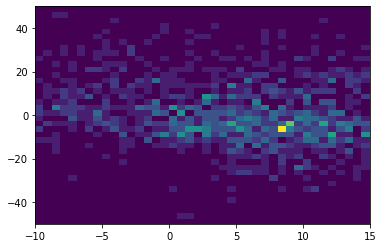

In [198]:
plt.hist2d(barotropic_flux/1e3, -0.0325 * densityforcing.values * depthwidth*np.sqrt(Ri.values)/1e3 + baroclinic_flux/1e3, range=[[-10, 15], [-50, 50]], bins=40);

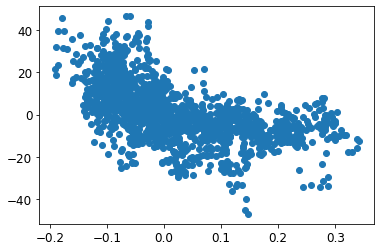

In [143]:
plt.plot(w_setup, -0.0325 * densityforcing.values * depthwidth*np.sqrt(Ri.values)/1e3 + baroclinic_flux/1e3, 'o')

In [238]:
y = baroclinic_flux.values
x = ssh.sossheig.rolling(window=30, center=True).mean()
z = densityforcing.values * np.sqrt(Ri) * depthwidth
X = np.column_stack((x, z))

model11 = sm.OLS(y, X, missing='drop').fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                          2.002e+04
Date:                Wed, 10 Nov 2021   Prob (F-statistic):                        0.00
Time:                        16:35:47   Log-Likelihood:                         -15459.
No. Observations:                1429   AIC:                                  3.092e+04
Df Residuals:                    1427   BIC:                                  3.093e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -5.658e+04   2708.954    -20.884      0.000   -6.19e+04   -5.13e+04
x2             0.0318      0.000    170.019      0.000       0.031       0.032
==============================================================================
Omnibus:                       12.553   Durbin-Watson:                   0.204
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               18.302
Skew:                           0.045   Prob(JB):                     0.000106
Kurtosis:                       3.547   Cond. No.                     1.61e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.61e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [199]:
y = baroclinic_flux.values
x = barotropic_flux.values
z = densityforcing.values * np.sqrt(Ri) * depthwidth
X = np.column_stack((x, z))

model11 = sm.OLS(y, X, missing='drop').fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                          1.672e+04
Date:                Wed, 10 Nov 2021   Prob (F-statistic):                        0.00
Time:                        16:16:21   Log-Likelihood:                         -15847.
No. Observations:                1453   AIC:                                  3.170e+04
Df Residuals:                    1451   BIC:                                  3.171e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3295      0.030    -11.110      0.000      -0.388      -0.271
x2             0.0342      0.000    175.539      0.000       0.034       0.035
==============================================================================
Omnibus:                       32.818   Durbin-Watson:                   0.201
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.537
Skew:                           0.303   Prob(JB):                     4.28e-09
Kurtosis:                       3.518   Cond. No.                         162.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [200]:
np.nanmean((baroclinic_flux.values - np.nanmean(baroclinic_flux.values))**2)

714048790.8615748

In [202]:
fit = 0.0342*densityforcing.values * np.sqrt(Ri.values) * depthwidth - 0.3295*barotropic_flux.values
print (np.nanmean((fit - np.nanmean(fit))**2))

483666177.36044043


In [194]:
y = baroclinic_flux.values/(densityforcing.values * depthwidth)
print (np.nanmean((y - np.nanmean(y))**2))
x = barotropic_flux.values
z = np.sqrt(Ri.values)
X = z

model11 = sm.OLS(y, X, missing='drop').fit()
model11.summary()

0.0006946478804702028


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                          2.801e+04
Date:                Wed, 10 Nov 2021   Prob (F-statistic):                        0.00
Time:                        16:12:24   Log-Likelihood:                          3822.3
No. Observations:                1453   AIC:                                     -7643.
Df Residuals:                    1452   BIC:                                     -7637.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0325      0.000    167.368      0.000       0.032       0.033
==============================================================================
Omnibus:                        7.775   Durbin-Watson:                   0.155
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                9.217
Skew:                           0.086   Prob(JB):                      0.00996
Kurtosis:                       3.351   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [195]:
fit = 0.0325*np.sqrt(Ri.values)
print (np.nanmean((fit - np.nanmean(fit))**2))
print (np.nanmean((fit - np.nanmean(fit))**2)/np.nanmean((y - np.nanmean(y))**2))

0.00036340217417041765
0.5231458763315207


In [182]:
fit = 1.673e4*densityforcing.values * np.sqrt(Ri.values)
print (np.nanmean((fit - np.nanmean(fit))**2))

413041551.42613953


In [183]:
print (413041551/714048790)

0.5784500398075039


58% of the variance explained

In [185]:
fit = 1.834e4*densityforcing.values * np.sqrt(Ri.values) - 1.3324*barotropic_flux.values
print (np.nanmean((fit - np.nanmean(fit))**2))

628005660.6140531


In [186]:
print (628005660/714048790)

0.8794996487564947


88% of the variance explained

In [187]:
y = baroclinic_flux.values
x = w_setup.values
z = densityforcing.values * np.sqrt(Ri)
X = np.column_stack((x, z))

model11 = sm.OLS(y, X, missing='drop').fit()
model11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                          2.157e+04
Date:                Wed, 10 Nov 2021   Prob (F-statistic):                        0.00
Time:                        16:05:43   Log-Likelihood:                         -15441.
No. Observations:                1432   AIC:                                  3.089e+04
Df Residuals:                    1430   BIC:                                  3.090e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -6.339e+04   2650.225    -23.919      0.000   -6.86e+04   -5.82e+04
x2          1.676e+04     81.177    206.417      0.000    1.66e+04    1.69e+04
==============================================================================
Omnibus:                       10.586   Durbin-Watson:                   0.233
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               14.307
Skew:                          -0.064   Prob(JB):                     0.000782
Kurtosis:                       3.473   Cond. No.                         32.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [188]:
fit = 1.676e4*densityforcing.values * np.sqrt(Ri.values) - 6.339e4*w_setup.values
print (np.nanmean((fit - np.nanmean(fit))**2))

652150905.1084213


In [189]:
print (652150905/714048790)

0.9133142078428562
